In [1]:
%config Completer.use_jedi = False
import sys
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

sys.path.append("/end/home/rh2310/morpho_repo/turing_codebase")
from turing.utils import *
from turing.tf_utils import *
import turing.pinns as tu
from turing.loss_functions import *

GPU = False
import os

if GPU:
    txt_device = 'gpu:0'
else:
    txt_device = 'cpu:0'    
    os.environ["CUDA_VISIBLE_DEVICES"]="-1"

2023-01-07 10:45:19.444454: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2023-01-07 10:45:32.860030: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2023-01-07 10:45:32.902958: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
pciBusID: 0000:2d:00.0 name: Quadro RTX 6000 computeCapability: 7.5
coreClock: 1.77GHz coreCount: 72 deviceMemorySize: 23.65GiB deviceMemoryBandwidth: 625.94GiB/s
2023-01-07 10:45:32.902996: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2023-01-07 10:45:32.905166: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.10
2023-01-07 10:45:32.907346: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcufft.so.10

# One dimensional functions

> Here, I try to model $y=f(x)$ with a neural net by using both $y$ and $y''=f''(x)$.

In [2]:
def Gaussian(x, loc=0.0, scale=1.0):
    return np.exp(-(x-loc)**2/(2*scale**2))

def Gaussian_df_dx(x, loc=0.0, scale=1.0):
    return (-(x-loc)/(scale**2))*Gaussian(x, loc, scale)

def Gaussian_d2f_dx2(x, loc=0.0, scale=1.0):
    return ((-1.0/scale**2)*Gaussian(x, loc, scale)
            -((x-loc)/(scale**2))*Gaussian_df_dx(x, loc, scale ))

data_1d_x = np.linspace(-4, 4, 512)[:,np.newaxis].astype(np.float32)
data_1d_y_gaussian = Gaussian(data_1d_x, 1.0)
data_1d_df_dx_gaussian = Gaussian_df_dx(data_1d_x, 1.0)
data_1d_d2f_dx2_gaussian = Gaussian_d2f_dx2(data_1d_x, 1.0)


ds_gaussian = TINN_Dataset(tf.float32, 
                           np.concatenate([data_1d_x, data_1d_y_gaussian], axis=1),
                           np.concatenate([data_1d_x, data_1d_df_dx_gaussian], axis=1))

In [2]:
@tf.function
def derivatives(pinn, x):
    y = pinn.net(x)
    p1, p2 = pinn.gradients(x, y)
    return y, p1, p2

In [4]:
layers = [1, 10, 1]
pinn = tu.NN(layers, 
             lb= np.min(data_1d_x),
             ub= np.max(data_1d_x),
             dtype=tf.float32)

# Initial output of an untrained network

2023-01-06 13:25:03.977403: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.10


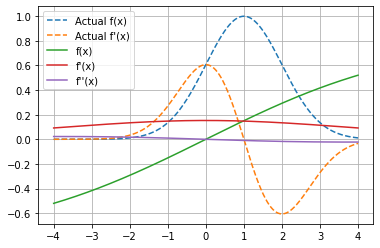

In [5]:
y, y_der_1, y_der_2 = derivatives(pinn, data_1d_x)
plt.plot(data_1d_x, data_1d_y_gaussian,'--', label="Actual f(x)")
plt.plot(data_1d_x, data_1d_df_dx_gaussian,'--', label="Actual f'(x)")

plt.plot(data_1d_x, y.numpy(), label="f(x)")
plt.plot(data_1d_x, y_der_1[0].numpy(), label="f'(x)")
plt.plot(data_1d_x, y_der_2[0].numpy(), label="f''(x)")
plt.legend()
plt.grid()
plt.show()

In [3]:
class Derivatives_single_Loss(tu.Loss):
    def __init__(
        self,
        dtype,
        loss_grad_type=Loss_Grad_Type.PINN,
        regularise=True,
        input_dim: int = 1,
        print_precision=".5f",
        **kwargs,
    ):
        super().__init__(
            name="Derivatives_Loss",
            loss_grad_type=loss_grad_type,
            regularise=regularise,
            residual_ret_num=1,
            residual_ret_names=("df/dx",),
            print_precision=print_precision,
            **kwargs,
        )
        self.input_dim = input_dim

    @tf.function
    def residual(self, pinn, x):
        inputs = x[:, : self.input_dim]
        outputs = pinn.net(inputs)
        df_dx = tf.gradients(outputs, inputs)[0]        
        df_dx_obs = x[:, self.input_dim : self.input_dim + 1]
        print(df_dx.shape)
        print(df_dx_obs.shape)
        return (df_dx - df_dx_obs,)

class Derivatives_double_Loss(tu.Loss):
    def __init__(
        self,
        dtype,
        loss_grad_type=Loss_Grad_Type.PINN,
        regularise=True,
        input_dim: int = 1,
        print_precision=".5f",
        **kwargs,
    ):
        super().__init__(
            name="Derivatives_Loss",
            loss_grad_type=loss_grad_type,
            regularise=regularise,
            residual_ret_num=2,
            residual_ret_names=("df/dx", "d2f/dx2"),
            print_precision=print_precision,
            **kwargs,
        )
        self.input_dim = input_dim

    @tf.function
    def residual(self, pinn, x):
        inputs = x[:, : self.input_dim]
        outputs = pinn.net(inputs)
        df_dx = tf.gradients(outputs, inputs)[0]
        d2f_dx2 = tf.gradients(df_dx, inputs)[0]
        df_dx_obs = x[:, self.input_dim : self.input_dim + 1]
        d2f_dx2_obs = x[:, self.input_dim+1 : self.input_dim + 2]
        print(df_dx.shape)
        print(d2f_dx2.shape)
        print(df_dx_obs.shape)
        print(d2f_dx2_obs.shape)
        return (df_dx - df_dx_obs, d2f_dx2-d2f_dx2_obs)


# Train the model

In [13]:
loss = Observation_Loss(layers, residual_ret_names=("f(x)",), print_precision = ".10f")
loss2 = Derivatives_single_Loss(pinn.dtype, print_precision = ".10f")
model = tu.TINN(pinn, [loss, loss2], L2(),
                optimizer=keras.optimizers.Adam(learning_rate=1e-4), print_precision = ".10f")
results = model.train(100000+1, 256, ds_gaussian, print_interval=5000,stop_threshold=5e-5,
                       regularise=False, sample_regularisations=False)


Start of epoch 0
(256, 1)
(256, 1)
total loss: 0.4055872727, total regularised loss: 0.4055872560
Observation_Loss -> 
(1)  f(x): 0.0964049650 
Derivatives_Loss -> 
(2)  df/dx: 0.1063886713 
Time taken: 0.60s

Start of epoch 5000
total loss: 0.2714011371, total regularised loss: 0.2714011371
Observation_Loss -> 
(1)  f(x): 0.0582264271 
Derivatives_Loss -> 
(2)  df/dx: 0.0774741415 
Time taken: 55.06s

Start of epoch 10000
total loss: 0.0945832576, total regularised loss: 0.0945832580
Observation_Loss -> 
(1)  f(x): 0.0096155067 
Derivatives_Loss -> 
(2)  df/dx: 0.0376761220 
Time taken: 54.91s

Start of epoch 15000
total loss: 0.0184620485, total regularised loss: 0.0184620488
Observation_Loss -> 
(1)  f(x): 0.0016232569 
Derivatives_Loss -> 
(2)  df/dx: 0.0076077673 
Time taken: 58.12s

Start of epoch 20000
total loss: 0.0010385161, total regularised loss: 0.0010385161
Observation_Loss -> 
(1)  f(x): 0.0000670021 
Derivatives_Loss -> 
(2)  df/dx: 0.0004522559 
Time taken: 56.07s

St

In [4]:
def RMSE(pred, actual):
    return np.sqrt(np.mean((pred-actual)**2))

# After training

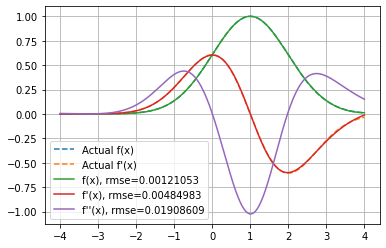

In [15]:
y, y_der_1, y_der_2 = derivatives(pinn, data_1d_x)
plt.plot(data_1d_x, data_1d_y_gaussian,'--', label="Actual f(x)")
plt.plot(data_1d_x, data_1d_df_dx_gaussian,'--', label="Actual f'(x)")


plt.plot(data_1d_x, y.numpy(), label=f"f(x), rmse={RMSE(data_1d_y_gaussian, y.numpy()):.8f}")
plt.plot(data_1d_x, y_der_1[0].numpy(),
         label=f"f'(x), rmse={RMSE(data_1d_df_dx_gaussian, y_der_1[0].numpy()):.8f}")

plt.plot(data_1d_x, y_der_2[0].numpy(), 
         label=f"f''(x), rmse={RMSE(data_1d_d2f_dx2_gaussian, y_der_2[0].numpy()):.8f}")
plt.legend()
plt.grid()
plt.show()

# Training by both derivatives

In [32]:
ds_gaussian2 = TINN_Dataset(tf.float32, 
                           np.concatenate([data_1d_x, data_1d_y_gaussian], axis=1),
                           np.concatenate([data_1d_x, data_1d_df_dx_gaussian, data_1d_d2f_dx2_gaussian], axis=1))

In [38]:
layers = [1, 10, 1]
pinn = tu.NN(layers, 
             lb= np.min(data_1d_x),
             ub= np.max(data_1d_x),
             dtype=tf.float32)

In [39]:
loss = Observation_Loss(layers, residual_ret_names=("f(x)",), print_precision = ".10f")
loss2 = Derivatives_double_Loss(pinn.dtype, print_precision = ".10f")
model = tu.TINN(pinn, [loss, loss2], L2(),
                optimizer=keras.optimizers.Adam(learning_rate=1e-4), print_precision = ".10f")
results = model.train(100000+1, 256, ds_gaussian2, print_interval=5000,stop_threshold=5e-5,
                       regularise=False, sample_regularisations=False)


Start of epoch 0
total loss: 1.3730925769, total regularised loss: 1.3730926514
Observation_Loss -> 
(1)  f(x): 0.3917098120 
Derivatives_Loss -> 
(2)  df/dx: 0.1286927536 (3)  d2f/dx2: 0.1661437210 
Time taken: 3.17s

Start of epoch 5000
total loss: 0.6075146459, total regularised loss: 0.6075146198
Observation_Loss -> 
(1)  f(x): 0.0660053995 
Derivatives_Loss -> 
(2)  df/dx: 0.0831804778 (3)  d2f/dx2: 0.1545714401 
Time taken: 79.64s

Start of epoch 10000
total loss: 0.2753923056, total regularised loss: 0.2753922939
Observation_Loss -> 
(1)  f(x): 0.0096708222 
Derivatives_Loss -> 
(2)  df/dx: 0.0374594163 (3)  d2f/dx2: 0.0905659087 
Time taken: 77.97s

Start of epoch 15000
total loss: 0.0420939397, total regularised loss: 0.0420939401
Observation_Loss -> 
(1)  f(x): 0.0011944876 
Derivatives_Loss -> 
(2)  df/dx: 0.0056130831 (3)  d2f/dx2: 0.0142393996 
Time taken: 84.46s

Start of epoch 20000
total loss: 0.0026256671, total regularised loss: 0.0026256670
Observation_Loss -> 
(1) 

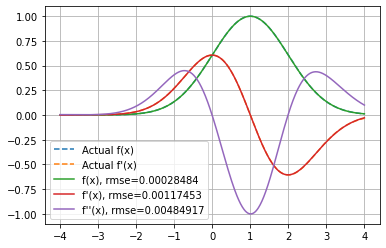

In [40]:
y, y_der_1, y_der_2 = derivatives(pinn, data_1d_x)
plt.plot(data_1d_x, data_1d_y_gaussian,'--', label="Actual f(x)")
plt.plot(data_1d_x, data_1d_df_dx_gaussian,'--', label="Actual f'(x)")


plt.plot(data_1d_x, y.numpy(), label=f"f(x), rmse={RMSE(data_1d_y_gaussian, y.numpy()):.8f}")
plt.plot(data_1d_x, y_der_1[0].numpy(),
         label=f"f'(x), rmse={RMSE(data_1d_df_dx_gaussian, y_der_1[0].numpy()):.8f}")

plt.plot(data_1d_x, y_der_2[0].numpy(), 
         label=f"f''(x), rmse={RMSE(data_1d_d2f_dx2_gaussian, y_der_2[0].numpy()):.8f}")
plt.legend()
plt.grid()
plt.show()

# Two-dimensional data

In [45]:
class Derivatives_2d_single_Loss(tu.Loss):
    def __init__(
        self,
        dtype,
        loss_grad_type=Loss_Grad_Type.PINN,
        regularise=True,
        input_dim: int = 2,
        print_precision=".5f",
        **kwargs,
    ):
        super().__init__(
            name="Derivatives_Loss",
            loss_grad_type=loss_grad_type,
            regularise=regularise,
            residual_ret_num=2,
            residual_ret_names=("df/dx", "df/dy"),
            print_precision=print_precision,
            **kwargs,
        )
        self.input_dim = input_dim

    @tf.function
    def residual(self, pinn, x):
        inputs = x[:, : self.input_dim]
        outputs = pinn.net(inputs)
        r = tf.gradients(outputs, inputs)[0]        
        df_dx = r[:,0:1]
        df_dy = r[:,1:2]
        df_dx_obs = x[:, self.input_dim : self.input_dim + 1]
        df_dy_obs = x[:, self.input_dim+1 : self.input_dim + 2]
        print(df_dx.shape)
        print(df_dy.shape)
        print(df_dx_obs.shape)
        print(df_dy_obs.shape)
        return (df_dx - df_dx_obs, df_dy - df_dy_obs)

class Derivatives_2d_double_Loss(tu.Loss):
    def __init__(
        self,
        dtype,
        loss_grad_type=Loss_Grad_Type.PINN,
        regularise=True,
        input_dim: int = 2,
        print_precision=".5f",
        **kwargs,
    ):
        super().__init__(
            name="Derivatives_Loss",
            loss_grad_type=loss_grad_type,
            regularise=regularise,
            residual_ret_num=4,
            residual_ret_names=("df/dx", "df/dy", "d2f/dx2", "d2f/dy2"),
            print_precision=print_precision,
            **kwargs,
        )
        self.input_dim = input_dim

    @tf.function
    def residual(self, pinn, x):
        inputs = x[:, : self.input_dim]
        outputs = pinn.net(inputs)
        r = tf.gradients(outputs, inputs)[0]
        df_dx = r[:,0:1]
        df_dy = r[:,1:2]
        r2 = tf.gradients(r, inputs)[0]
        d2f_dx2 = r2[:,0:1]
        d2f_dy2 = r2[:,1:2]
        df_dx_obs = x[:, self.input_dim : self.input_dim + 1]
        df_dy_obs = x[:, self.input_dim+1 : self.input_dim + 2]
        d2f_dx2_obs = x[:, self.input_dim+2 : self.input_dim + 3]
        d2f_dy2_obs = x[:, self.input_dim+3 : self.input_dim + 4]
        
        print(df_dx.shape)
        print(df_dy.shape)
        print(d2f_dx2.shape)
        print(d2f_dy2.shape)
        print(df_dx_obs.shape)
        print(df_dy_obs.shape)
        print(d2f_dx2_obs.shape)
        print(d2f_dy2_obs.shape)

        return (df_dx - df_dx_obs,
                df_dy - df_dy_obs,
                d2f_dx2-d2f_dx2_obs,
                d2f_dy2-d2f_dy2_obs)

class Derivatives_2d_second_der_Loss(tu.Loss):
    def __init__(
        self,
        dtype,
        loss_grad_type=Loss_Grad_Type.PINN,
        regularise=True,
        input_dim: int = 2,
        print_precision=".5f",
        **kwargs,
    ):
        super().__init__(
            name="Derivatives_Loss",
            loss_grad_type=loss_grad_type,
            regularise=regularise,
            residual_ret_num=2,
            residual_ret_names=("d2f/dx2", "d2f/dy2"),
            print_precision=print_precision,
            **kwargs,
        )
        self.input_dim = input_dim

    @tf.function
    def residual(self, pinn, x):
        inputs = x[:, : self.input_dim]
        outputs = pinn.net(inputs)
        r = tf.gradients(outputs, inputs)[0]
        r2 = tf.gradients(r, inputs)[0]
        d2f_dx2 = r2[:,0:1]
        d2f_dy2 = r2[:,1:2]
        d2f_dx2_obs = x[:, self.input_dim : self.input_dim + 1]
        d2f_dy2_obs = x[:, self.input_dim+1 : self.input_dim + 2]
        
        #print(df_dx.shape)
        #print(df_dy.shape)
        #print(d2f_dx2.shape)
        #print(d2f_dy2.shape)
        #print(df_dx_obs.shape)
        #print(df_dy_obs.shape)
        #print(d2f_dx2_obs.shape)
        #print(d2f_dy2_obs.shape)

        return (d2f_dx2-d2f_dx2_obs,
                d2f_dy2-d2f_dy2_obs
               )

class Derivatives_2d_second_der_Loss_2(tu.Loss):
    def __init__(
        self,
        dtype,
        loss_grad_type=Loss_Grad_Type.PINN,
        regularise=True,
        input_dim: int = 2,
        print_precision=".5f",
        **kwargs,
    ):
        super().__init__(
            name="Derivatives_Loss",
            loss_grad_type=loss_grad_type,
            regularise=regularise,
            residual_ret_num=1,
            residual_ret_names=("d2f/dx2",),
            print_precision=print_precision,
            **kwargs,
        )
        self.input_dim = input_dim

    @tf.function
    def residual(self, pinn, x):
        inputs = x[:, : self.input_dim]
        outputs = pinn.net(inputs)
        r = tf.gradients(outputs, inputs)[0]
        r2 = tf.gradients(r, inputs)[0]
        d2f_dx2 = r2[:,0:1]
        #d2f_dy2 = r2[:,1:2]
        d2f_dx2_obs = x[:, self.input_dim : self.input_dim + 1]
        #d2f_dy2_obs = x[:, self.input_dim+1 : self.input_dim + 2]
        
        #print(df_dx.shape)
        #print(df_dy.shape)
        #print(d2f_dx2.shape)
        #print(d2f_dy2.shape)
        #print(df_dx_obs.shape)
        #print(df_dy_obs.shape)
        #print(d2f_dx2_obs.shape)
        #print(d2f_dy2_obs.shape)

        return (d2f_dx2-d2f_dx2_obs,
                #d2f_dy2-d2f_dy2_obs
               )

In [6]:
def to_2d(x):
    return x.reshape((data_2d_x.shape[0], data_2d_x.shape[0]))

In [40]:
def Gaussian_2d(x, y, locx=0.0, locy=0.0, scalex=1.0, scaley=1.0):
    return np.exp(-(x-locx)**2/(2*scalex**2)-(y-locy)**2/(2*scaley**2))

def Gaussian_2d_df_dx(x, y, locx=0.0, locy=0.0, scalex=1.0, scaley=1.0):
    return (-(x-locx)/(scalex**2))*Gaussian_2d(x, y, locx, locy, scalex, scaley)

def Gaussian_2d_df_dy(x, y, locx=0.0, locy=0.0, scalex=1.0, scaley=1.0):
    return (-(y-locy)/(scaley**2))*Gaussian_2d(x, y, locx, locy, scalex, scaley)

def Gaussian_2d_d2f_dx2(x, y, locx=0.0, locy=0.0, scalex=1.0, scaley=1.0):
    return ((-1.0/scalex**2)*Gaussian_2d(x, y, locx, locy, scalex, scaley)
            -((x-locx)/(scalex**2))*Gaussian_2d_df_dx(x, y, locx, locy, scalex, scaley))

def Gaussian_2d_d2f_dy2(x, y, locx=0.0, locy=0.0, scalex=1.0, scaley=1.0):
    return ((-1.0/scaley**2)*Gaussian_2d(x, y, locx, locy, scalex, scaley) 
            -((y-locy)/(scaley**2))*Gaussian_2d_df_dy(x, y, locx, locy, scalex, scaley))


data_2d_x = np.linspace(0, 2, 128)[:,np.newaxis].astype(np.float32)
data_2d_y = np.linspace(-2, 2, 128)[:,np.newaxis].astype(np.float32)
X,Y = np.meshgrid(data_2d_x, data_2d_y,indexing='ij')
data_2d_z_gaussian = Gaussian_2d(X, Y, 1.0, 0.5, .2, .7)
data_input = np.concatenate([X.flatten()[:,np.newaxis],
                             Y.flatten()[:,np.newaxis]], 
                              axis=1)

data_2d_df_dx = Gaussian_2d_df_dx(X, Y, 1.0, 0.5, .2, .7)
data_2d_df_dy = Gaussian_2d_df_dy(X, Y, 1.0, 0.5, .2, .7)

data_2d_d2f_dx2 = Gaussian_2d_d2f_dx2(X, Y, 1.0, 0.5, .2, .7)
data_2d_d2f_dy2 = Gaussian_2d_d2f_dy2(X, Y, 1.0, 0.5, .2, .7)

ds_gaussian_2d_f = TINN_Dataset(tf.float32, 
                              np.concatenate([X.flatten()[:,np.newaxis],
                                              Y.flatten()[:,np.newaxis],
                                              data_2d_z_gaussian.flatten()[:,np.newaxis]], axis=1)
                              )

ds_gaussian_2d = TINN_Dataset(tf.float32, 
                              np.concatenate([X.flatten()[:,np.newaxis],
                                              Y.flatten()[:,np.newaxis],
                                              data_2d_z_gaussian.flatten()[:,np.newaxis]], axis=1),
                              np.concatenate([X.flatten()[:,np.newaxis],
                                              Y.flatten()[:,np.newaxis],
                                              data_2d_df_dx.flatten()[:,np.newaxis],
                                              data_2d_df_dy.flatten()[:,np.newaxis]], axis=1)
                              )

ds_gaussian_2d_all_ders = TINN_Dataset(tf.float32, 
                              np.concatenate([X.flatten()[:,np.newaxis],
                                              Y.flatten()[:,np.newaxis],
                                              data_2d_z_gaussian.flatten()[:,np.newaxis]], axis=1),
                              np.concatenate([X.flatten()[:,np.newaxis],
                                              Y.flatten()[:,np.newaxis],
                                              data_2d_df_dx.flatten()[:,np.newaxis],
                                              data_2d_df_dy.flatten()[:,np.newaxis],
                                              data_2d_d2f_dx2.flatten()[:,np.newaxis],
                                              data_2d_d2f_dy2.flatten()[:,np.newaxis]], axis=1)
                              )

ds_gaussian_2d_second_ders = TINN_Dataset(tf.float32, 
                              np.concatenate([X.flatten()[:,np.newaxis],
                                              Y.flatten()[:,np.newaxis],
                                              data_2d_z_gaussian.flatten()[:,np.newaxis]], axis=1),
                              np.concatenate([X.flatten()[:,np.newaxis],
                                              Y.flatten()[:,np.newaxis],
                                              data_2d_d2f_dx2.flatten()[:,np.newaxis],
                                              data_2d_d2f_dy2.flatten()[:,np.newaxis]], axis=1)
                              )


ds_gaussian_2d_second_ders2 = TINN_Dataset(tf.float32, 
                              np.concatenate([X.flatten()[:,np.newaxis],
                                              Y.flatten()[:,np.newaxis],
                                              data_2d_z_gaussian.flatten()[:,np.newaxis]], axis=1),
                              np.concatenate([X.flatten()[:,np.newaxis],
                                              Y.flatten()[:,np.newaxis],
                                              data_2d_d2f_dx2.flatten()[:,np.newaxis]], axis=1)
                              )


def plot(X, Y, Z, title=""):
    plt.title(title)
    plt.contourf(X, Y, Z)
    plt.colorbar()


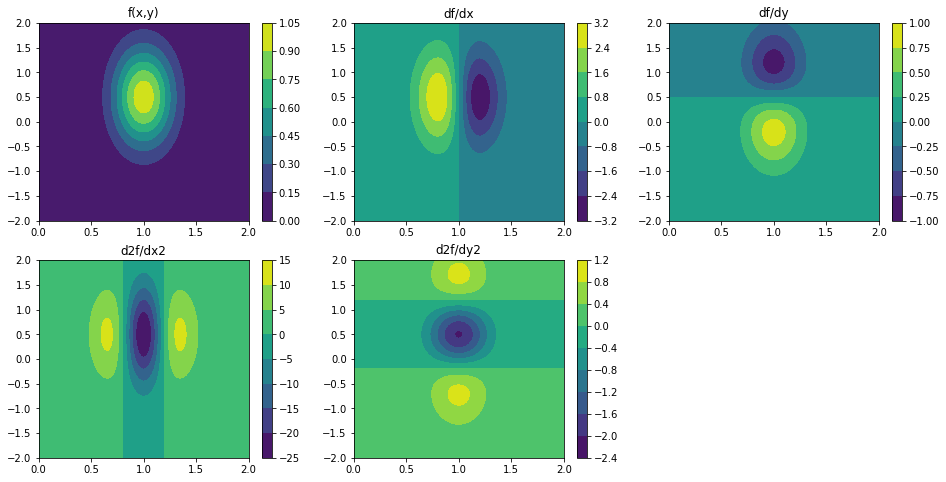

In [8]:
_ = plt.figure(figsize=(16,8))
plt.subplot(231)
plot(X, Y, data_2d_z_gaussian, "f(x,y)")
plt.subplot(232)
plot(X, Y, Gaussian_2d_df_dx(X, Y, 1.0, 0.5, .2, .7), "df/dx")
plt.subplot(233)
plot(X, Y, Gaussian_2d_df_dy(X, Y, 1.0, 0.5, .2, .7), "df/dy")
plt.subplot(234)
plot(X, Y, Gaussian_2d_d2f_dx2(X, Y, 1.0, 0.5, .2, .7), "d2f/dx2")
plt.subplot(235)
plot(X, Y, Gaussian_2d_d2f_dy2(X, Y, 1.0, 0.5, .2, .7), "d2f/dy2")
plt.show()

In [23]:
layers2 = [2, 128, 128, 1]
pinn2 = tu.NN(layers2, 
             lb= np.amin(np.concatenate([data_2d_x, data_2d_y], axis=1), 0),
             ub= np.amax(np.concatenate([data_2d_x, data_2d_y], axis=1), 0),
             dtype=tf.float32)

# Initial output of an untrained network

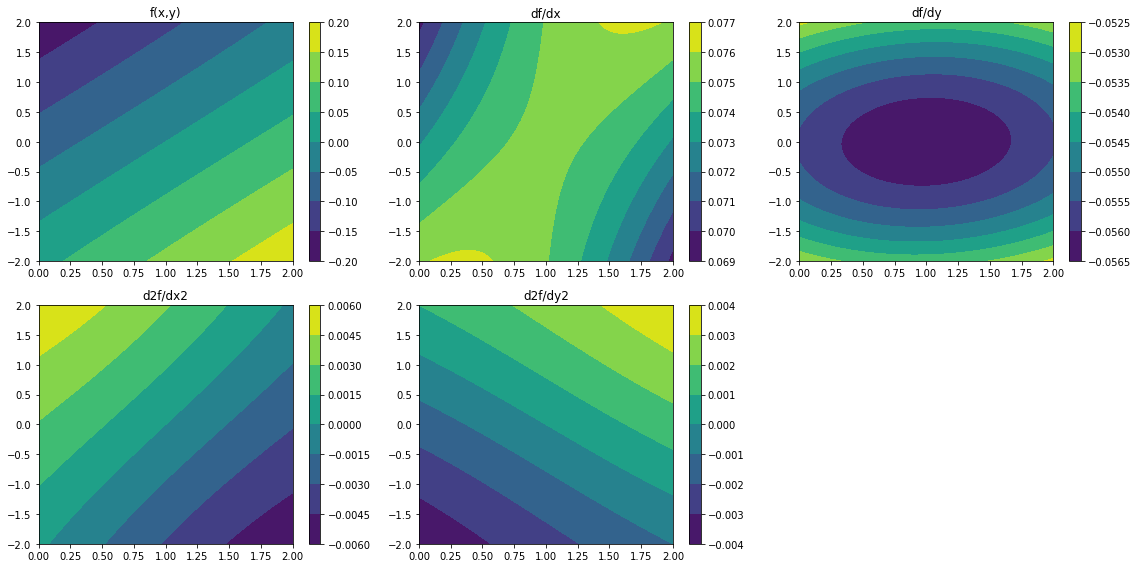

In [24]:
y, y_der_1, y_der_2 = derivatives(pinn2, data_input)


_ = plt.figure(figsize=(16,8))
plt.subplot(231)
plot(X, Y, to_2d(y.numpy()), "f(x,y)")
plt.subplot(232)
plot(X, Y, to_2d(y_der_1[0].numpy()[:,0]), "df/dx")
plt.subplot(233)
plot(X, Y, to_2d(y_der_1[0].numpy()[:,1]), "df/dy")
plt.subplot(234)
plot(X, Y, to_2d(y_der_2[0].numpy()[:,0]), "d2f/dx2")
plt.subplot(235)
plot(X, Y, to_2d(y_der_2[0].numpy()[:,1]), "d2f/dy2")
plt.tight_layout()
plt.show()

# Train the model

In [ ]:
loss2_1 = Observation_Loss(layers2, residual_ret_names=("f(x,y)",))
loss2_2 = Derivatives_2d_single_Loss(pinn2.dtype, print_precision = ".10f")
model2 = tu.TINN(pinn2, [loss2_1, loss2_2], L2(), optimizer=keras.optimizers.Adam(learning_rate=1e-4))
results2 = model2.train(100000+1, 4096, ds_gaussian_2d, print_interval=5000,stop_threshold=1e-6,
                        regularise=False, sample_regularisations=False)

# After training

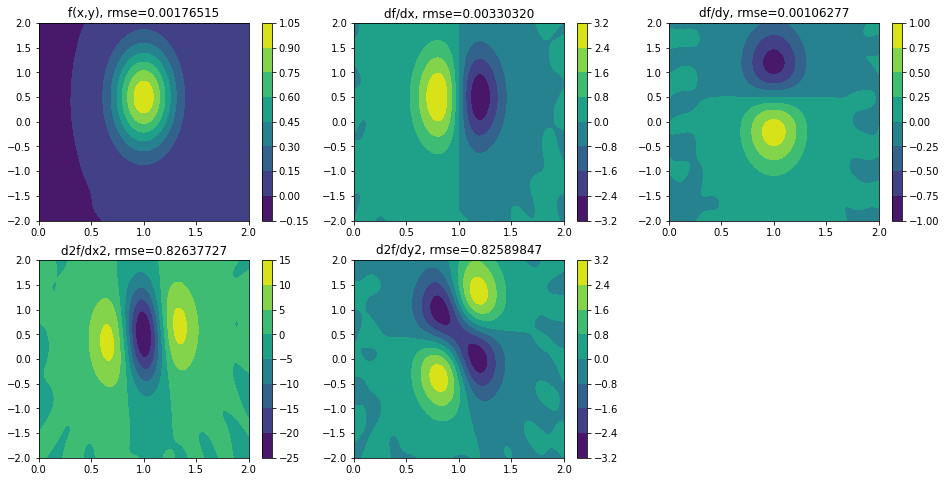

In [47]:
y, y_der_1, y_der_2 = derivatives(pinn2, data_input)


_ = plt.figure(figsize=(16,8))
plt.subplot(231)
plot(X, Y, to_2d(y.numpy()), f"f(x,y), rmse={RMSE(data_2d_z_gaussian, to_2d(y.numpy())):.8f}")
plt.subplot(232)
plot(X, Y, to_2d(y_der_1[0].numpy()[:,0]), f"df/dx, rmse={RMSE(data_2d_df_dx, to_2d(y_der_1[0].numpy()[:,0])):.8f}")
plt.subplot(233)
plot(X, Y, to_2d(y_der_1[0].numpy()[:,1]), f"df/dy, rmse={RMSE(data_2d_df_dy, to_2d(y_der_1[0].numpy()[:,1])):.8f}")
plt.subplot(234)
plot(X, Y, to_2d(y_der_2[0].numpy()[:,0]), f"d2f/dx2, rmse={RMSE(data_2d_d2f_dx2, to_2d(y_der_2[0].numpy()[:,0])):.8f}")
plt.subplot(235)
plot(X, Y, to_2d(y_der_2[0].numpy()[:,1]), f"d2f/dy2, rmse={RMSE(data_2d_d2f_dy2, to_2d(y_der_2[0].numpy()[:,1])):.8f}")
plt.show()

In [24]:
model2.save(".", "model2d_tanh_first_ders")

# Including second derivatives

In [24]:
def RMSE(pred, actual, sqrt=True):
    if sqrt:
        return np.sqrt(np.mean((pred-actual)**2))
    else:
        return np.mean((pred-actual)**2)

In [61]:
layers3 = [2, 128, 128, 1]
pinn3 = tu.NN(layers3, 
             lb= np.amin(np.concatenate([data_2d_x, data_2d_y], axis=1), 0),
             ub= np.amax(np.concatenate([data_2d_x, data_2d_y], axis=1), 0),
             dtype=tf.float32)

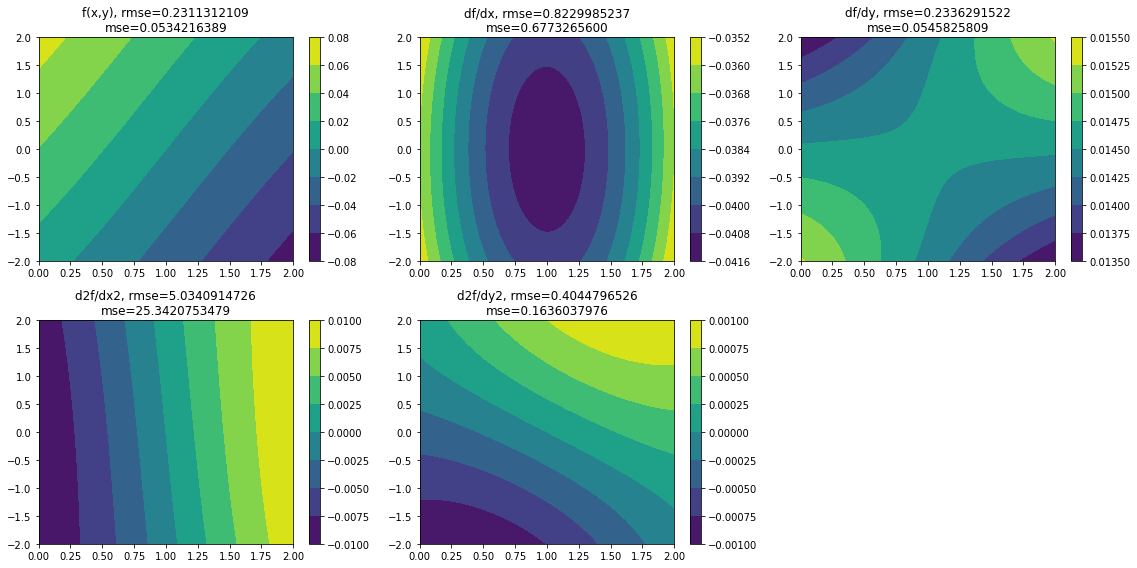

In [62]:
y, y_der_1, y_der_2 = derivatives(pinn3, data_input)


_ = plt.figure(figsize=(16,8))
plt.subplot(231)
plot(X, Y, to_2d(y.numpy()), 
     f"f(x,y), rmse={RMSE(data_2d_z_gaussian, to_2d(y.numpy())):.10f}\n"
     f"mse={RMSE(data_2d_z_gaussian, to_2d(y.numpy()), False):.10f}")
plt.subplot(232)
plot(X, Y, to_2d(y_der_1[0].numpy()[:,0]), 
     f"df/dx, rmse={RMSE(data_2d_df_dx, to_2d(y_der_1[0].numpy()[:,0])):.10f}\n"
     f"mse={RMSE(data_2d_df_dx, to_2d(y_der_1[0].numpy()[:,0]), False):.10f}")
plt.subplot(233)
plot(X, Y, to_2d(y_der_1[0].numpy()[:,1]), 
     f"df/dy, rmse={RMSE(data_2d_df_dy, to_2d(y_der_1[0].numpy()[:,1])):.10f}\n"
     f"mse={RMSE(data_2d_df_dy, to_2d(y_der_1[0].numpy()[:,1]),False):.10f}")
plt.subplot(234)
plot(X, Y, to_2d(y_der_2[0].numpy()[:,0]), 
     f"d2f/dx2, rmse={RMSE(data_2d_d2f_dx2, to_2d(y_der_2[0].numpy()[:,0])):.10f}\n"
    f"mse={RMSE(data_2d_d2f_dx2, to_2d(y_der_2[0].numpy()[:,0]),False):.10f}")
plt.subplot(235)
plot(X, Y, to_2d(y_der_2[0].numpy()[:,1]), 
     f"d2f/dy2, rmse={RMSE(data_2d_d2f_dy2, to_2d(y_der_2[0].numpy()[:,1])):.10f}\n"
    f"mse={RMSE(data_2d_d2f_dy2, to_2d(y_der_2[0].numpy()[:,1]),False):.10f}")
plt.tight_layout()
plt.show()

In [65]:
loss2_1 = Observation_Loss(layers3, residual_ret_names=("f(x,y)",), print_precision = ".10f")
loss2_2 = Derivatives_2d_second_der_Loss(pinn3.dtype, print_precision = ".10f")
model3 = tu.TINN(pinn3, [loss2_1, loss2_2], L2(),
                 optimizer=keras.optimizers.Adam(learning_rate=1e-4), print_precision = ".10f")
results3 = model3.train(100000+1, 4096, ds_gaussian_2d_second_ders, print_interval=5000,stop_threshold=1e-6,
                        regularise=False, sample_regularisations=False)


Start of epoch 0
total loss: 102.2390149250, total regularised loss: 102.2390213013
Observation_Loss -> 
(1)  f(x,y): 0.0533842746 
Derivatives_Loss -> 
(2)  d2f/dx2: 25.3427813947 (3)  d2f/dy2: 0.1635883340 
Time taken: 3.99s

Start of epoch 5000
total loss: 2.6227009135, total regularised loss: 2.6227006912
Observation_Loss -> 
(1)  f(x,y): 0.0015104214 
Derivatives_Loss -> 
(2)  d2f/dx2: 0.0969047868 (3)  d2f/dy2: 0.5572600123 
Time taken: 224.28s

Start of epoch 10000
total loss: 2.5979353969, total regularised loss: 2.5979354382
Observation_Loss -> 
(1)  f(x,y): 0.0013689761 
Derivatives_Loss -> 
(2)  d2f/dx2: 0.0927888502 (3)  d2f/dy2: 0.5553260269 
Time taken: 222.66s

Start of epoch 15000
total loss: 2.5938970855, total regularised loss: 2.5938971043
Observation_Loss -> 
(1)  f(x,y): 0.0013371287 
Derivatives_Loss -> 
(2)  d2f/dx2: 0.0921754336 (3)  d2f/dy2: 0.5549617205 
Time taken: 233.23s

Start of epoch 20000
total loss: 2.5918355939, total regularised loss: 2.5918354988
O

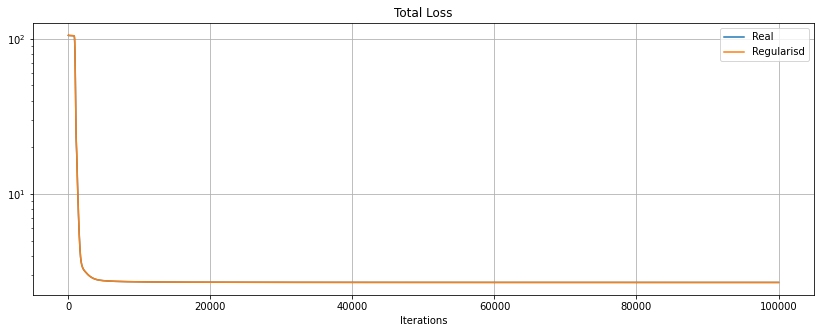

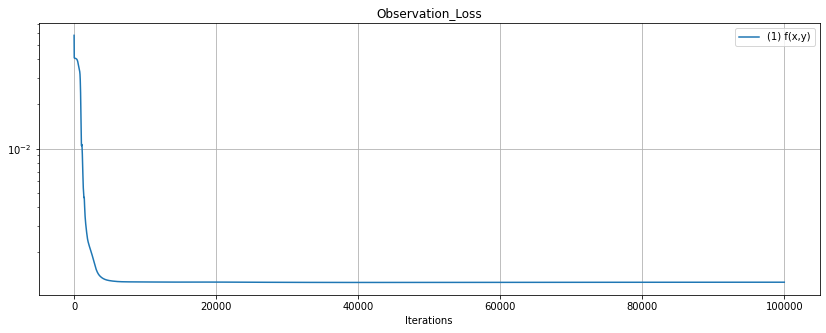

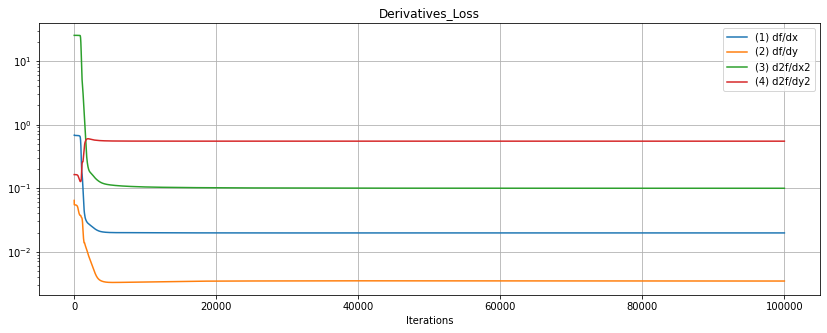

In [45]:
plot_result(merge_dict(results3), model3,start=0)

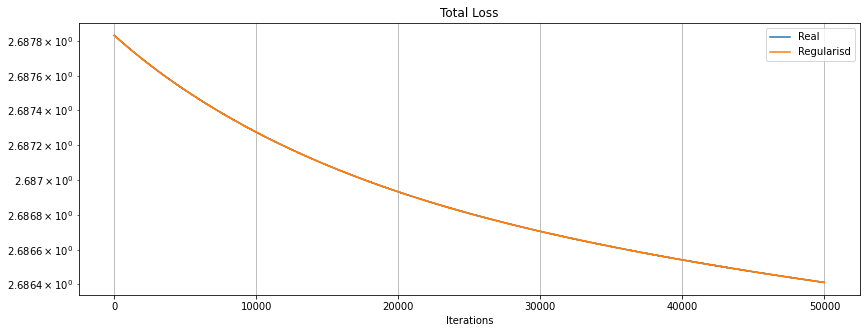

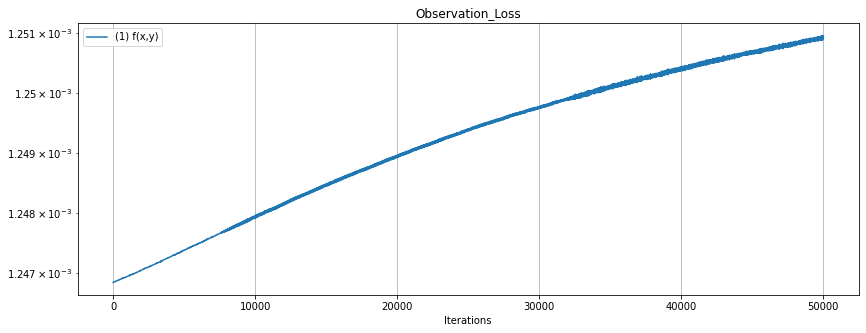

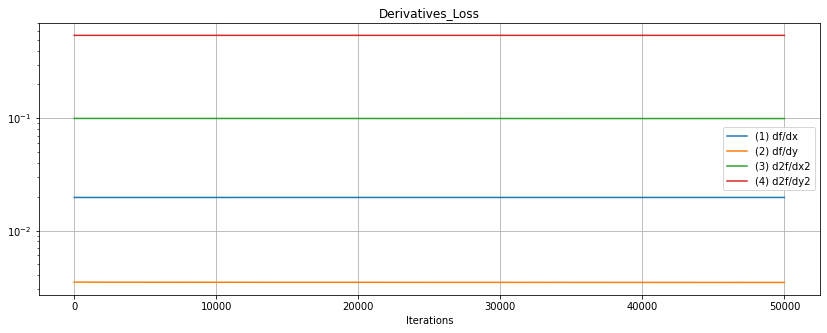

In [44]:
plot_result(merge_dict(results3), model3,start=50000)

In [9]:
layers4 = [2, 128, 128, 1]
pinn4 = tu.NN(layers4, 
             lb= np.amin(np.concatenate([data_2d_x, data_2d_y], axis=1), 0),
             ub= np.amax(np.concatenate([data_2d_x, data_2d_y], axis=1), 0),
             dtype=tf.float32)

In [14]:
loss2_1 = Observation_Loss(layers4, residual_ret_names=("f(x,y)",), print_precision = ".10f")
#loss2_2 = Derivatives_2d_single_Loss(pinn2.dtype, print_precision = ".10f")
model2 = tu.TINN(pinn4, [loss2_1], L2(), 
                 optimizer=keras.optimizers.Adam(learning_rate=1e-4), print_precision = ".10f")
results2 = model2.train(200000+1, 16384, ds_gaussian_2d_f, print_interval=5000,stop_threshold=1e-8,
                        regularise=False, sample_regularisations=False)


Start of epoch 0


2023-01-07 10:49:28.881917: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
2023-01-07 10:49:29.090439: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.10


total loss: 0.0554901846, total regularised loss: 0.0554901846
Observation_Loss -> 
(1)  f(x,y): 0.0554901846 
Time taken: 2.50s

Start of epoch 5000
total loss: 0.0000622276, total regularised loss: 0.0000622276
Observation_Loss -> 
(1)  f(x,y): 0.0000622276 
Time taken: 88.31s

Start of epoch 10000
total loss: 0.0000118022, total regularised loss: 0.0000118022
Observation_Loss -> 
(1)  f(x,y): 0.0000118022 
Time taken: 87.07s

Start of epoch 15000
total loss: 0.0000035720, total regularised loss: 0.0000035720
Observation_Loss -> 
(1)  f(x,y): 0.0000035720 
Time taken: 87.19s

Start of epoch 20000
total loss: 0.0000019168, total regularised loss: 0.0000019168
Observation_Loss -> 
(1)  f(x,y): 0.0000019168 
Time taken: 87.51s

Start of epoch 25000
total loss: 0.0000015260, total regularised loss: 0.0000015260
Observation_Loss -> 
(1)  f(x,y): 0.0000015260 
Time taken: 88.05s

Start of epoch 30000
total loss: 0.0000011883, total regularised loss: 0.0000011883
Observation_Loss -> 
(1)  f

In [28]:
model2.optimizer.lr.assign(5e-5)

<tf.Variable 'UnreadVariable' shape=() dtype=float32, numpy=5e-05>

In [29]:
results3 = model2.train(100000+1, 16384, ds_gaussian_2d_f, print_interval=5000,stop_threshold=5e-8,
                        regularise=False, sample_regularisations=False)


Start of epoch 0
total loss: 0.0000002963, total regularised loss: 0.0000002963
Observation_Loss -> 
(1)  f(x,y): 0.0000002963 
Time taken: 1.07s

Start of epoch 5000
total loss: 0.0000002900, total regularised loss: 0.0000002900
Observation_Loss -> 
(1)  f(x,y): 0.0000002900 
Time taken: 93.28s

Start of epoch 10000
total loss: 0.0000002836, total regularised loss: 0.0000002836
Observation_Loss -> 
(1)  f(x,y): 0.0000002836 
Time taken: 95.12s

Start of epoch 15000
total loss: 0.0000002785, total regularised loss: 0.0000002785
Observation_Loss -> 
(1)  f(x,y): 0.0000002785 
Time taken: 95.20s

Start of epoch 20000
total loss: 0.0000002732, total regularised loss: 0.0000002732
Observation_Loss -> 
(1)  f(x,y): 0.0000002732 
Time taken: 95.35s

Start of epoch 25000
total loss: 0.0000002683, total regularised loss: 0.0000002683
Observation_Loss -> 
(1)  f(x,y): 0.0000002683 
Time taken: 94.93s

Start of epoch 30000
total loss: 0.0000002636, total regularised loss: 0.0000002636
Observati

In [30]:
model2.save(".", "model_tanh_2d_f_x_y_only")

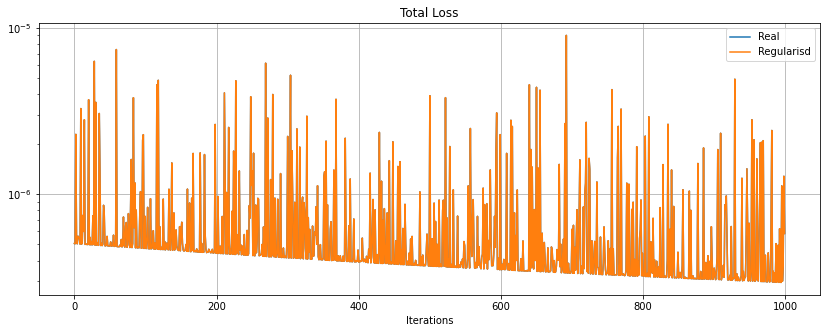

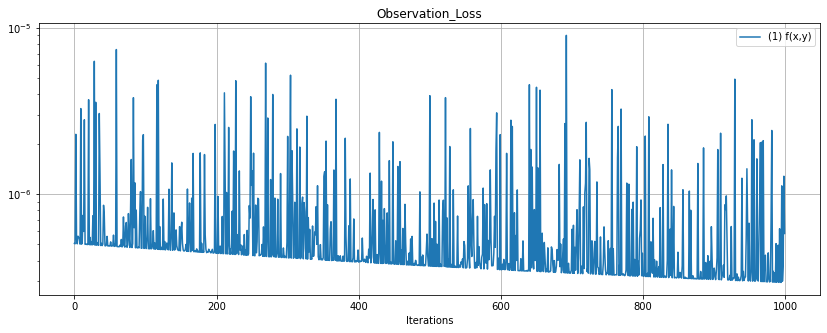

In [21]:
plot_result(merge_dict(results2), model2,start=100000, skip=100)

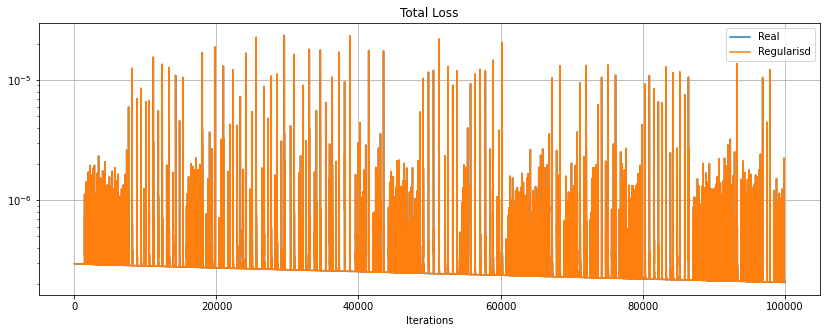

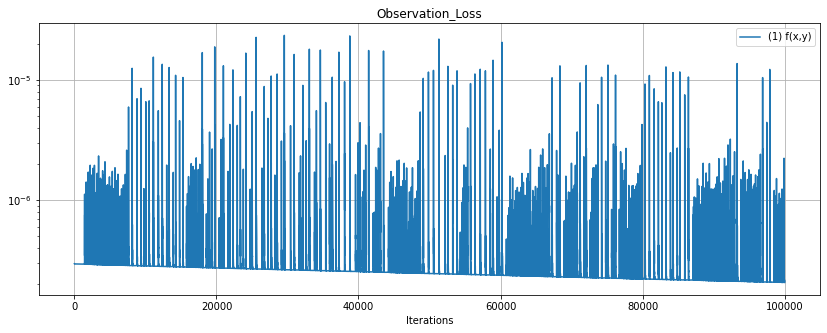

In [31]:
plot_result(merge_dict(results3), model2,start=0)

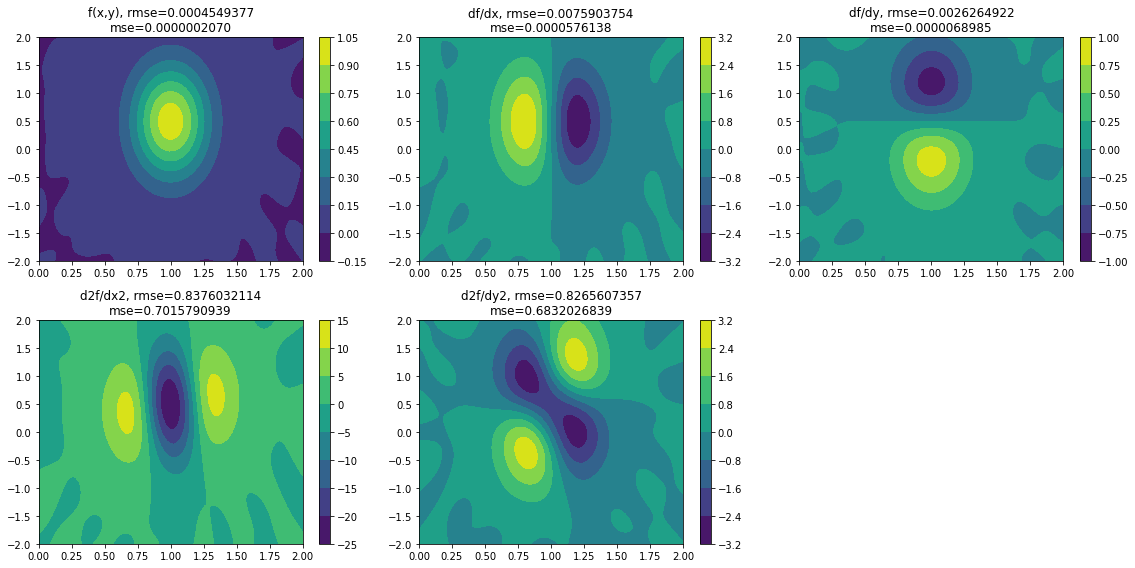

In [32]:
y, y_der_1, y_der_2 = derivatives(pinn4, data_input)


_ = plt.figure(figsize=(16,8))
plt.subplot(231)
plot(X, Y, to_2d(y.numpy()), 
     f"f(x,y), rmse={RMSE(data_2d_z_gaussian, to_2d(y.numpy())):.10f}\n"
     f"mse={RMSE(data_2d_z_gaussian, to_2d(y.numpy()), False):.10f}")
plt.subplot(232)
plot(X, Y, to_2d(y_der_1[0].numpy()[:,0]), 
     f"df/dx, rmse={RMSE(data_2d_df_dx, to_2d(y_der_1[0].numpy()[:,0])):.10f}\n"
     f"mse={RMSE(data_2d_df_dx, to_2d(y_der_1[0].numpy()[:,0]), False):.10f}")
plt.subplot(233)
plot(X, Y, to_2d(y_der_1[0].numpy()[:,1]), 
     f"df/dy, rmse={RMSE(data_2d_df_dy, to_2d(y_der_1[0].numpy()[:,1])):.10f}\n"
     f"mse={RMSE(data_2d_df_dy, to_2d(y_der_1[0].numpy()[:,1]),False):.10f}")
plt.subplot(234)
plot(X, Y, to_2d(y_der_2[0].numpy()[:,0]), 
     f"d2f/dx2, rmse={RMSE(data_2d_d2f_dx2, to_2d(y_der_2[0].numpy()[:,0])):.10f}\n"
    f"mse={RMSE(data_2d_d2f_dx2, to_2d(y_der_2[0].numpy()[:,0]),False):.10f}")
plt.subplot(235)
plot(X, Y, to_2d(y_der_2[0].numpy()[:,1]), 
     f"d2f/dy2, rmse={RMSE(data_2d_d2f_dy2, to_2d(y_der_2[0].numpy()[:,1])):.10f}\n"
    f"mse={RMSE(data_2d_d2f_dy2, to_2d(y_der_2[0].numpy()[:,1]),False):.10f}")
plt.tight_layout()
plt.show()

In [46]:
model2 = tu.TINN.restore(".", "model_tanh_2d_f_x_y_only", ds_gaussian_2d_f)
pinn4 = model2.pinn

In [47]:
loss2_1 = Observation_Loss(layers4, residual_ret_names=("f(x,y)",), print_precision = ".10f")
loss2_2 = Derivatives_2d_second_der_Loss_2(pinn4.dtype, print_precision = ".10f")
model3 = tu.TINN(pinn4, [loss2_1, loss2_2], L2(), 
                 optimizer=keras.optimizers.Adam(learning_rate=1e-4), print_precision = ".10f")
results3_1 = model3.train(200000+1, 16384, ds_gaussian_2d_second_ders2, print_interval=5000,stop_threshold=1e-8,
                        regularise=False, sample_regularisations=False)


Start of epoch 0
total loss: 0.7015792413, total regularised loss: 0.7015792131
Observation_Loss -> 
(1)  f(x,y): 0.0000002070 
Derivatives_Loss -> 
(2)  d2f/dx2: 0.7015790343 
Time taken: 5.11s

Start of epoch 5000
total loss: 0.0028168496, total regularised loss: 0.0028168496
Observation_Loss -> 
(1)  f(x,y): 0.0024381736 
Derivatives_Loss -> 
(2)  d2f/dx2: 0.0003786759 
Time taken: 143.91s

Start of epoch 10000
total loss: 0.0025624031, total regularised loss: 0.0025624032
Observation_Loss -> 
(1)  f(x,y): 0.0024098107 
Derivatives_Loss -> 
(2)  d2f/dx2: 0.0001525924 
Time taken: 144.33s

Start of epoch 15000
total loss: 0.0024992198, total regularised loss: 0.0024992200
Observation_Loss -> 
(1)  f(x,y): 0.0024079224 
Derivatives_Loss -> 
(2)  d2f/dx2: 0.0000912974 
Time taken: 144.20s

Start of epoch 20000
total loss: 0.0024974223, total regularised loss: 0.0024974223
Observation_Loss -> 
(1)  f(x,y): 0.0024077920 
Derivatives_Loss -> 
(2)  d2f/dx2: 0.0000896303 
Time taken: 143.5

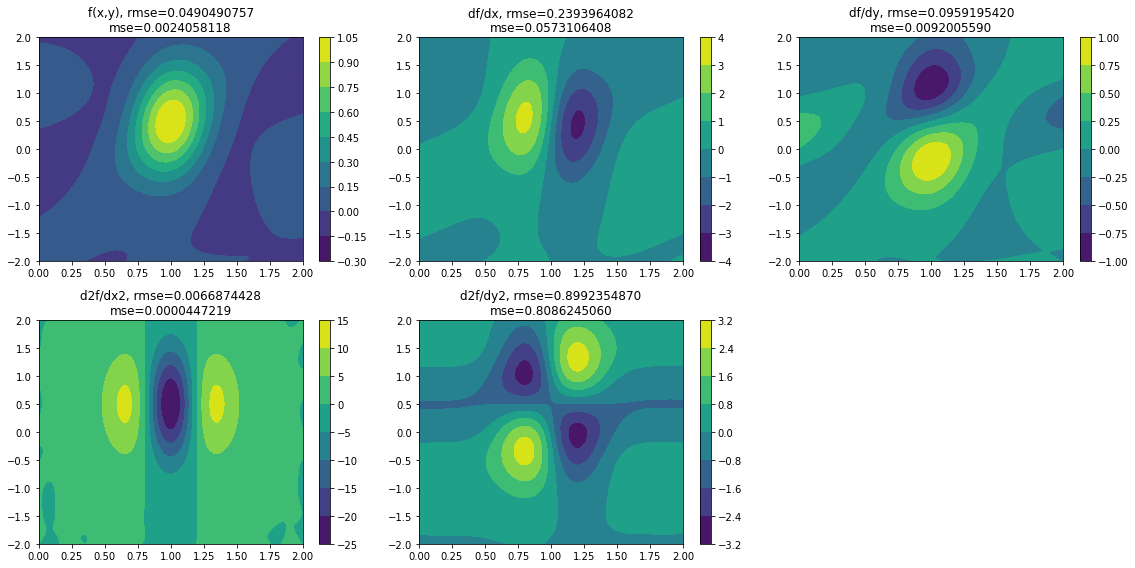

In [48]:
y, y_der_1, y_der_2 = derivatives(pinn4, data_input)


_ = plt.figure(figsize=(16,8))
plt.subplot(231)
plot(X, Y, to_2d(y.numpy()), 
     f"f(x,y), rmse={RMSE(data_2d_z_gaussian, to_2d(y.numpy())):.10f}\n"
     f"mse={RMSE(data_2d_z_gaussian, to_2d(y.numpy()), False):.10f}")
plt.subplot(232)
plot(X, Y, to_2d(y_der_1[0].numpy()[:,0]), 
     f"df/dx, rmse={RMSE(data_2d_df_dx, to_2d(y_der_1[0].numpy()[:,0])):.10f}\n"
     f"mse={RMSE(data_2d_df_dx, to_2d(y_der_1[0].numpy()[:,0]), False):.10f}")
plt.subplot(233)
plot(X, Y, to_2d(y_der_1[0].numpy()[:,1]), 
     f"df/dy, rmse={RMSE(data_2d_df_dy, to_2d(y_der_1[0].numpy()[:,1])):.10f}\n"
     f"mse={RMSE(data_2d_df_dy, to_2d(y_der_1[0].numpy()[:,1]),False):.10f}")
plt.subplot(234)
plot(X, Y, to_2d(y_der_2[0].numpy()[:,0]), 
     f"d2f/dx2, rmse={RMSE(data_2d_d2f_dx2, to_2d(y_der_2[0].numpy()[:,0])):.10f}\n"
    f"mse={RMSE(data_2d_d2f_dx2, to_2d(y_der_2[0].numpy()[:,0]),False):.10f}")
plt.subplot(235)
plot(X, Y, to_2d(y_der_2[0].numpy()[:,1]), 
     f"d2f/dy2, rmse={RMSE(data_2d_d2f_dy2, to_2d(y_der_2[0].numpy()[:,1])):.10f}\n"
    f"mse={RMSE(data_2d_d2f_dy2, to_2d(y_der_2[0].numpy()[:,1]),False):.10f}")
plt.tight_layout()
plt.show()

In [49]:
results3_2 = model3.train(300000+1, 4096, ds_gaussian_2d_second_ders2, print_interval=5000,stop_threshold=1e-8,
                        regularise=True, sample_regularisations=True)


Start of epoch 0
total loss: 0.0148311200, total regularised loss: 0.0148311201
Observation_Loss -> 
(1)  f(x,y): 0.0030227740 
Derivatives_Loss -> 
(2)  d2f/dx2: 0.0006850060 
(1) lambdas : 1.0000000000 (2) lambdas : 1.0000000000 
Time taken: 7.00s

Start of epoch 5000
total loss: 0.0142540971, total regularised loss: 0.0159954224
Observation_Loss -> 
(1)  f(x,y): 0.0020673639 
Derivatives_Loss -> 
(2)  d2f/dx2: 0.0014961604 
(1) lambdas : 1.7621304989 (2) lambdas : 0.2378695011 
Time taken: 382.81s

Start of epoch 10000
total loss: 0.0142752110, total regularised loss: 0.0160222761
Observation_Loss -> 
(1)  f(x,y): 0.0020711071 
Derivatives_Loss -> 
(2)  d2f/dx2: 0.0014976956 
(1) lambdas : 1.7616972923 (2) lambdas : 0.2383027375 
Time taken: 382.71s

Start of epoch 15000
total loss: 0.0143044218, total regularised loss: 0.0160579029
Observation_Loss -> 
(1)  f(x,y): 0.0020756799 
Derivatives_Loss -> 
(2)  d2f/dx2: 0.0015004255 
(1) lambdas : 1.7609512806 (2) lambdas : 0.2390486002 


Start of epoch 160000
total loss: 0.0150320202, total regularised loss: 0.0161703322
Observation_Loss -> 
(1)  f(x,y): 0.0020685318 
Derivatives_Loss -> 
(2)  d2f/dx2: 0.0016894732 
(1) lambdas : 1.7755451202 (2) lambdas : 0.2244547904 
Time taken: 380.80s

Start of epoch 165000
total loss: 0.0147166215, total regularised loss: 0.0160874706
Observation_Loss -> 
(1)  f(x,y): 0.0020631217 
Derivatives_Loss -> 
(2)  d2f/dx2: 0.0016160336 
(1) lambdas : 1.7652418613 (2) lambdas : 0.2347580343 
Time taken: 383.54s

Start of epoch 170000
total loss: 0.0146983954, total regularised loss: 0.0160805825
Observation_Loss -> 
(1)  f(x,y): 0.0020631644 
Derivatives_Loss -> 
(2)  d2f/dx2: 0.0016114345 
(1) lambdas : 1.7666069269 (2) lambdas : 0.2333930880 
Time taken: 380.63s

Start of epoch 175000
total loss: 0.0146659266, total regularised loss: 0.0160892252
Observation_Loss -> 
(1)  f(x,y): 0.0020658184 
Derivatives_Loss -> 
(2)  d2f/dx2: 0.0016006632 
(1) lambdas : 1.7663424015 (2) lambdas : 0.

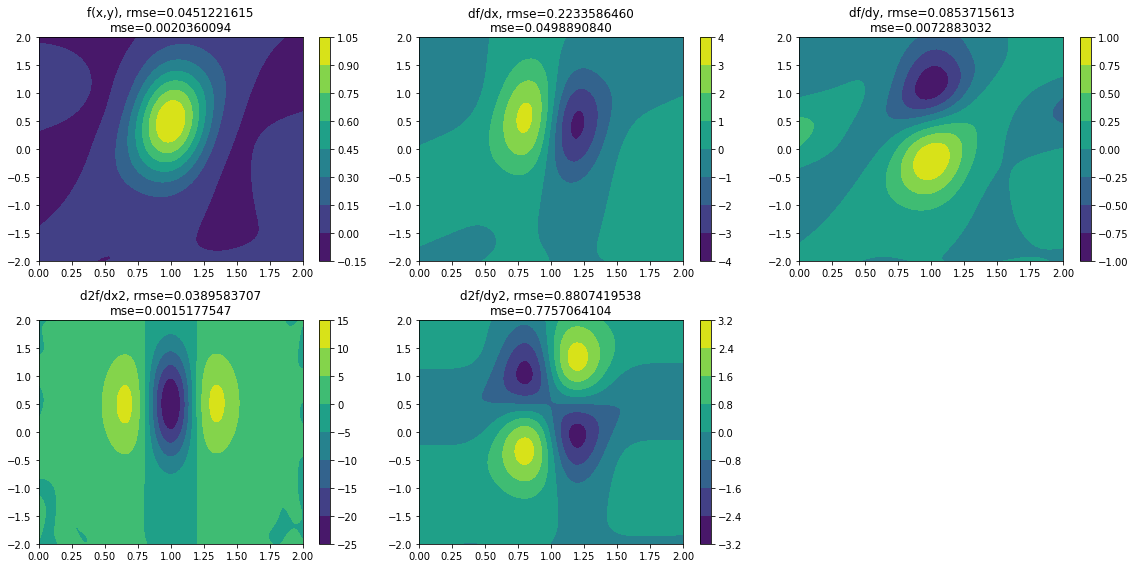

In [50]:
y, y_der_1, y_der_2 = derivatives(pinn4, data_input)


_ = plt.figure(figsize=(16,8))
plt.subplot(231)
plot(X, Y, to_2d(y.numpy()), 
     f"f(x,y), rmse={RMSE(data_2d_z_gaussian, to_2d(y.numpy())):.10f}\n"
     f"mse={RMSE(data_2d_z_gaussian, to_2d(y.numpy()), False):.10f}")
plt.subplot(232)
plot(X, Y, to_2d(y_der_1[0].numpy()[:,0]), 
     f"df/dx, rmse={RMSE(data_2d_df_dx, to_2d(y_der_1[0].numpy()[:,0])):.10f}\n"
     f"mse={RMSE(data_2d_df_dx, to_2d(y_der_1[0].numpy()[:,0]), False):.10f}")
plt.subplot(233)
plot(X, Y, to_2d(y_der_1[0].numpy()[:,1]), 
     f"df/dy, rmse={RMSE(data_2d_df_dy, to_2d(y_der_1[0].numpy()[:,1])):.10f}\n"
     f"mse={RMSE(data_2d_df_dy, to_2d(y_der_1[0].numpy()[:,1]),False):.10f}")
plt.subplot(234)
plot(X, Y, to_2d(y_der_2[0].numpy()[:,0]), 
     f"d2f/dx2, rmse={RMSE(data_2d_d2f_dx2, to_2d(y_der_2[0].numpy()[:,0])):.10f}\n"
    f"mse={RMSE(data_2d_d2f_dx2, to_2d(y_der_2[0].numpy()[:,0]),False):.10f}")
plt.subplot(235)
plot(X, Y, to_2d(y_der_2[0].numpy()[:,1]), 
     f"d2f/dy2, rmse={RMSE(data_2d_d2f_dy2, to_2d(y_der_2[0].numpy()[:,1])):.10f}\n"
    f"mse={RMSE(data_2d_d2f_dy2, to_2d(y_der_2[0].numpy()[:,1]),False):.10f}")
plt.tight_layout()
plt.show()

In [54]:
model5 = tu.TINN.restore(".", "model_tanh_2d_f_x_y_only", ds_gaussian_2d_f)
pinn5 = model5.pinn

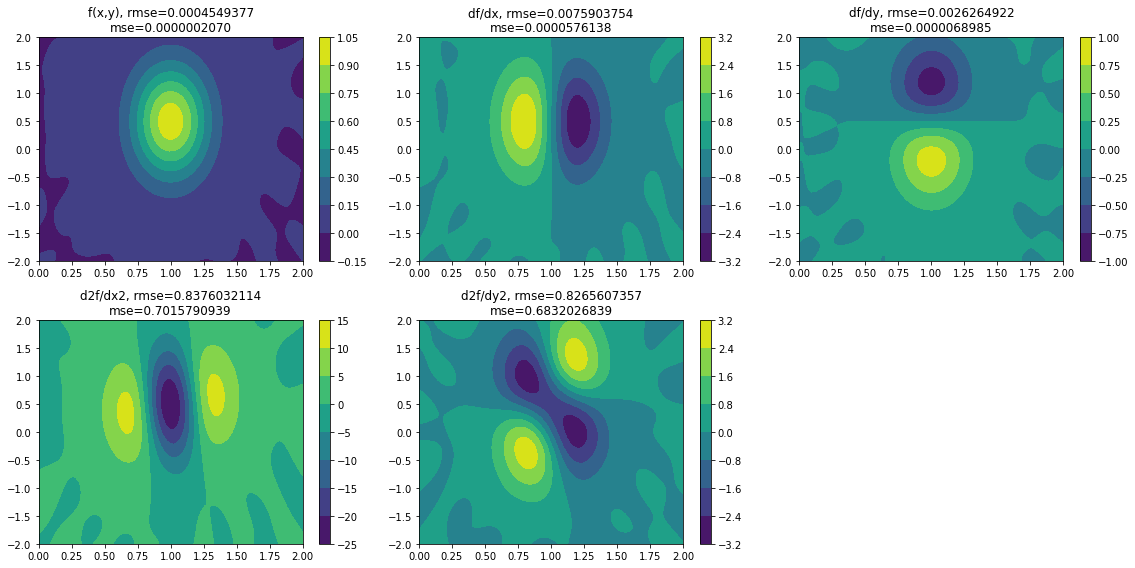

In [55]:
y, y_der_1, y_der_2 = derivatives(pinn5, data_input)


_ = plt.figure(figsize=(16,8))
plt.subplot(231)
plot(X, Y, to_2d(y.numpy()), 
     f"f(x,y), rmse={RMSE(data_2d_z_gaussian, to_2d(y.numpy())):.10f}\n"
     f"mse={RMSE(data_2d_z_gaussian, to_2d(y.numpy()), False):.10f}")
plt.subplot(232)
plot(X, Y, to_2d(y_der_1[0].numpy()[:,0]), 
     f"df/dx, rmse={RMSE(data_2d_df_dx, to_2d(y_der_1[0].numpy()[:,0])):.10f}\n"
     f"mse={RMSE(data_2d_df_dx, to_2d(y_der_1[0].numpy()[:,0]), False):.10f}")
plt.subplot(233)
plot(X, Y, to_2d(y_der_1[0].numpy()[:,1]), 
     f"df/dy, rmse={RMSE(data_2d_df_dy, to_2d(y_der_1[0].numpy()[:,1])):.10f}\n"
     f"mse={RMSE(data_2d_df_dy, to_2d(y_der_1[0].numpy()[:,1]),False):.10f}")
plt.subplot(234)
plot(X, Y, to_2d(y_der_2[0].numpy()[:,0]), 
     f"d2f/dx2, rmse={RMSE(data_2d_d2f_dx2, to_2d(y_der_2[0].numpy()[:,0])):.10f}\n"
    f"mse={RMSE(data_2d_d2f_dx2, to_2d(y_der_2[0].numpy()[:,0]),False):.10f}")
plt.subplot(235)
plot(X, Y, to_2d(y_der_2[0].numpy()[:,1]), 
     f"d2f/dy2, rmse={RMSE(data_2d_d2f_dy2, to_2d(y_der_2[0].numpy()[:,1])):.10f}\n"
    f"mse={RMSE(data_2d_d2f_dy2, to_2d(y_der_2[0].numpy()[:,1]),False):.10f}")
plt.tight_layout()
plt.show()

In [56]:
loss2_1 = Observation_Loss(layers4, residual_ret_names=("f(x,y)",), print_precision = ".10f")
loss2_2 = Derivatives_2d_second_der_Loss_2(pinn4.dtype, print_precision = ".10f")
model5 = tu.TINN(pinn5, [loss2_1, loss2_2], L2(), 
                 optimizer=keras.optimizers.Adam(learning_rate=1e-4),
                 loss_penalty_power=3,
                 print_precision = ".10f")
results3_1 = model5.train(200000+1, 16384//2, ds_gaussian_2d_second_ders2, print_interval=5000,stop_threshold=1e-8,
                        regularise=True, sample_regularisations=True)


Start of epoch 0
total loss: 1.3763712685, total regularised loss: 1.3763712645
Observation_Loss -> 
(1)  f(x,y): 0.0000186583 
Derivatives_Loss -> 
(2)  d2f/dx2: 0.6881669760 
(1) lambdas : 1.0000000000 (2) lambdas : 1.0000000000 
Time taken: 8.58s

Start of epoch 5000
total loss: 0.0082625656, total regularised loss: 0.0086354259
Observation_Loss -> 
(1)  f(x,y): 0.0022045991 
Derivatives_Loss -> 
(2)  d2f/dx2: 0.0019266837 
(1) lambdas : 1.6723160744 (2) lambdas : 0.3276840448 
Time taken: 222.71s

Start of epoch 10000
total loss: 0.0078895665, total regularised loss: 0.0082903253
Observation_Loss -> 
(1)  f(x,y): 0.0021103465 
Derivatives_Loss -> 
(2)  d2f/dx2: 0.0018344368 
(1) lambdas : 1.7261765003 (2) lambdas : 0.2738234997 
Time taken: 219.69s

Start of epoch 15000
total loss: 0.0077034594, total regularised loss: 0.0081027877
Observation_Loss -> 
(1)  f(x,y): 0.0020581218 
Derivatives_Loss -> 
(2)  d2f/dx2: 0.0017936078 
(1) lambdas : 1.7527167797 (2) lambdas : 0.2472833246 


Start of epoch 150000
total loss: 0.0075572584, total regularised loss: 0.0079641901
Observation_Loss -> 
(1)  f(x,y): 0.0020198385 
Derivatives_Loss -> 
(2)  d2f/dx2: 0.0017587906 
(1) lambdas : 1.7793514729 (2) lambdas : 0.2206485868 
Time taken: 220.57s

Start of epoch 155000
total loss: 0.0075562091, total regularised loss: 0.0079636443
Observation_Loss -> 
(1)  f(x,y): 0.0020198677 
Derivatives_Loss -> 
(2)  d2f/dx2: 0.0017582369 
(1) lambdas : 1.7804186344 (2) lambdas : 0.2195814103 
Time taken: 226.36s

Start of epoch 160000
total loss: 0.0075711785, total regularised loss: 0.0079637812
Observation_Loss -> 
(1)  f(x,y): 0.0020187310 
Derivatives_Loss -> 
(2)  d2f/dx2: 0.0017668583 
(1) lambdas : 1.7792217731 (2) lambdas : 0.2207782865 
Time taken: 226.18s

Start of epoch 165000
total loss: 0.0075587119, total regularised loss: 0.0079624970
Observation_Loss -> 
(1)  f(x,y): 0.0020191332 
Derivatives_Loss -> 
(2)  d2f/dx2: 0.0017602228 
(1) lambdas : 1.7796347141 (2) lambdas : 0.